In [96]:
# Import required libraries
import numpy as np
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier,GradientBoostingRegressor,GradientBoostingClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,r2_score,roc_auc_score,precision_score,recall_score,f1_score
from sklearn.model_selection import KFold,GridSearchCV,RandomizedSearchCV
import os
from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV
from sklearn.model_selection import train_test_split

### Data pre-processing

Let's name the columns in the dataframe

In [63]:
columns=["engine_id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5","sensor6","sensor7","sensor8",
         "sensor9","sensor10","sensor11","sensor12","sensor13","sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
         ,"sensor20","sensor21","sensor22","sensor23"]

Load the dataset

In [64]:
train=pd.read_csv("Dataset/train_FD001.txt",sep=" ",names=columns)
test=pd.read_csv("Dataset/test_FD001.txt",sep=" ",names=columns)
test_results=pd.read_csv("Dataset/RUL_FD001.txt",sep=" ",header=None)

In [65]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 28 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   engine_id  20631 non-null  int64  
 1   cycle      20631 non-null  int64  
 2   op1        20631 non-null  float64
 3   op2        20631 non-null  float64
 4   op3        20631 non-null  float64
 5   sensor1    20631 non-null  float64
 6   sensor2    20631 non-null  float64
 7   sensor3    20631 non-null  float64
 8   sensor4    20631 non-null  float64
 9   sensor5    20631 non-null  float64
 10  sensor6    20631 non-null  float64
 11  sensor7    20631 non-null  float64
 12  sensor8    20631 non-null  float64
 13  sensor9    20631 non-null  float64
 14  sensor10   20631 non-null  float64
 15  sensor11   20631 non-null  float64
 16  sensor12   20631 non-null  float64
 17  sensor13   20631 non-null  float64
 18  sensor14   20631 non-null  float64
 19  sensor15   20631 non-null  float64
 20  sensor

In [66]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13096 entries, 0 to 13095
Data columns (total 28 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   engine_id  13096 non-null  int64  
 1   cycle      13096 non-null  int64  
 2   op1        13096 non-null  float64
 3   op2        13096 non-null  float64
 4   op3        13096 non-null  float64
 5   sensor1    13096 non-null  float64
 6   sensor2    13096 non-null  float64
 7   sensor3    13096 non-null  float64
 8   sensor4    13096 non-null  float64
 9   sensor5    13096 non-null  float64
 10  sensor6    13096 non-null  float64
 11  sensor7    13096 non-null  float64
 12  sensor8    13096 non-null  float64
 13  sensor9    13096 non-null  float64
 14  sensor10   13096 non-null  float64
 15  sensor11   13096 non-null  float64
 16  sensor12   13096 non-null  float64
 17  sensor13   13096 non-null  float64
 18  sensor14   13096 non-null  float64
 19  sensor15   13096 non-null  float64
 20  sensor

In [67]:
train.head()

,engine_id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [68]:
print('Unique ID: ',train['engine_id'].unique())

Unique ID:  [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]


Engine cycle lifetime

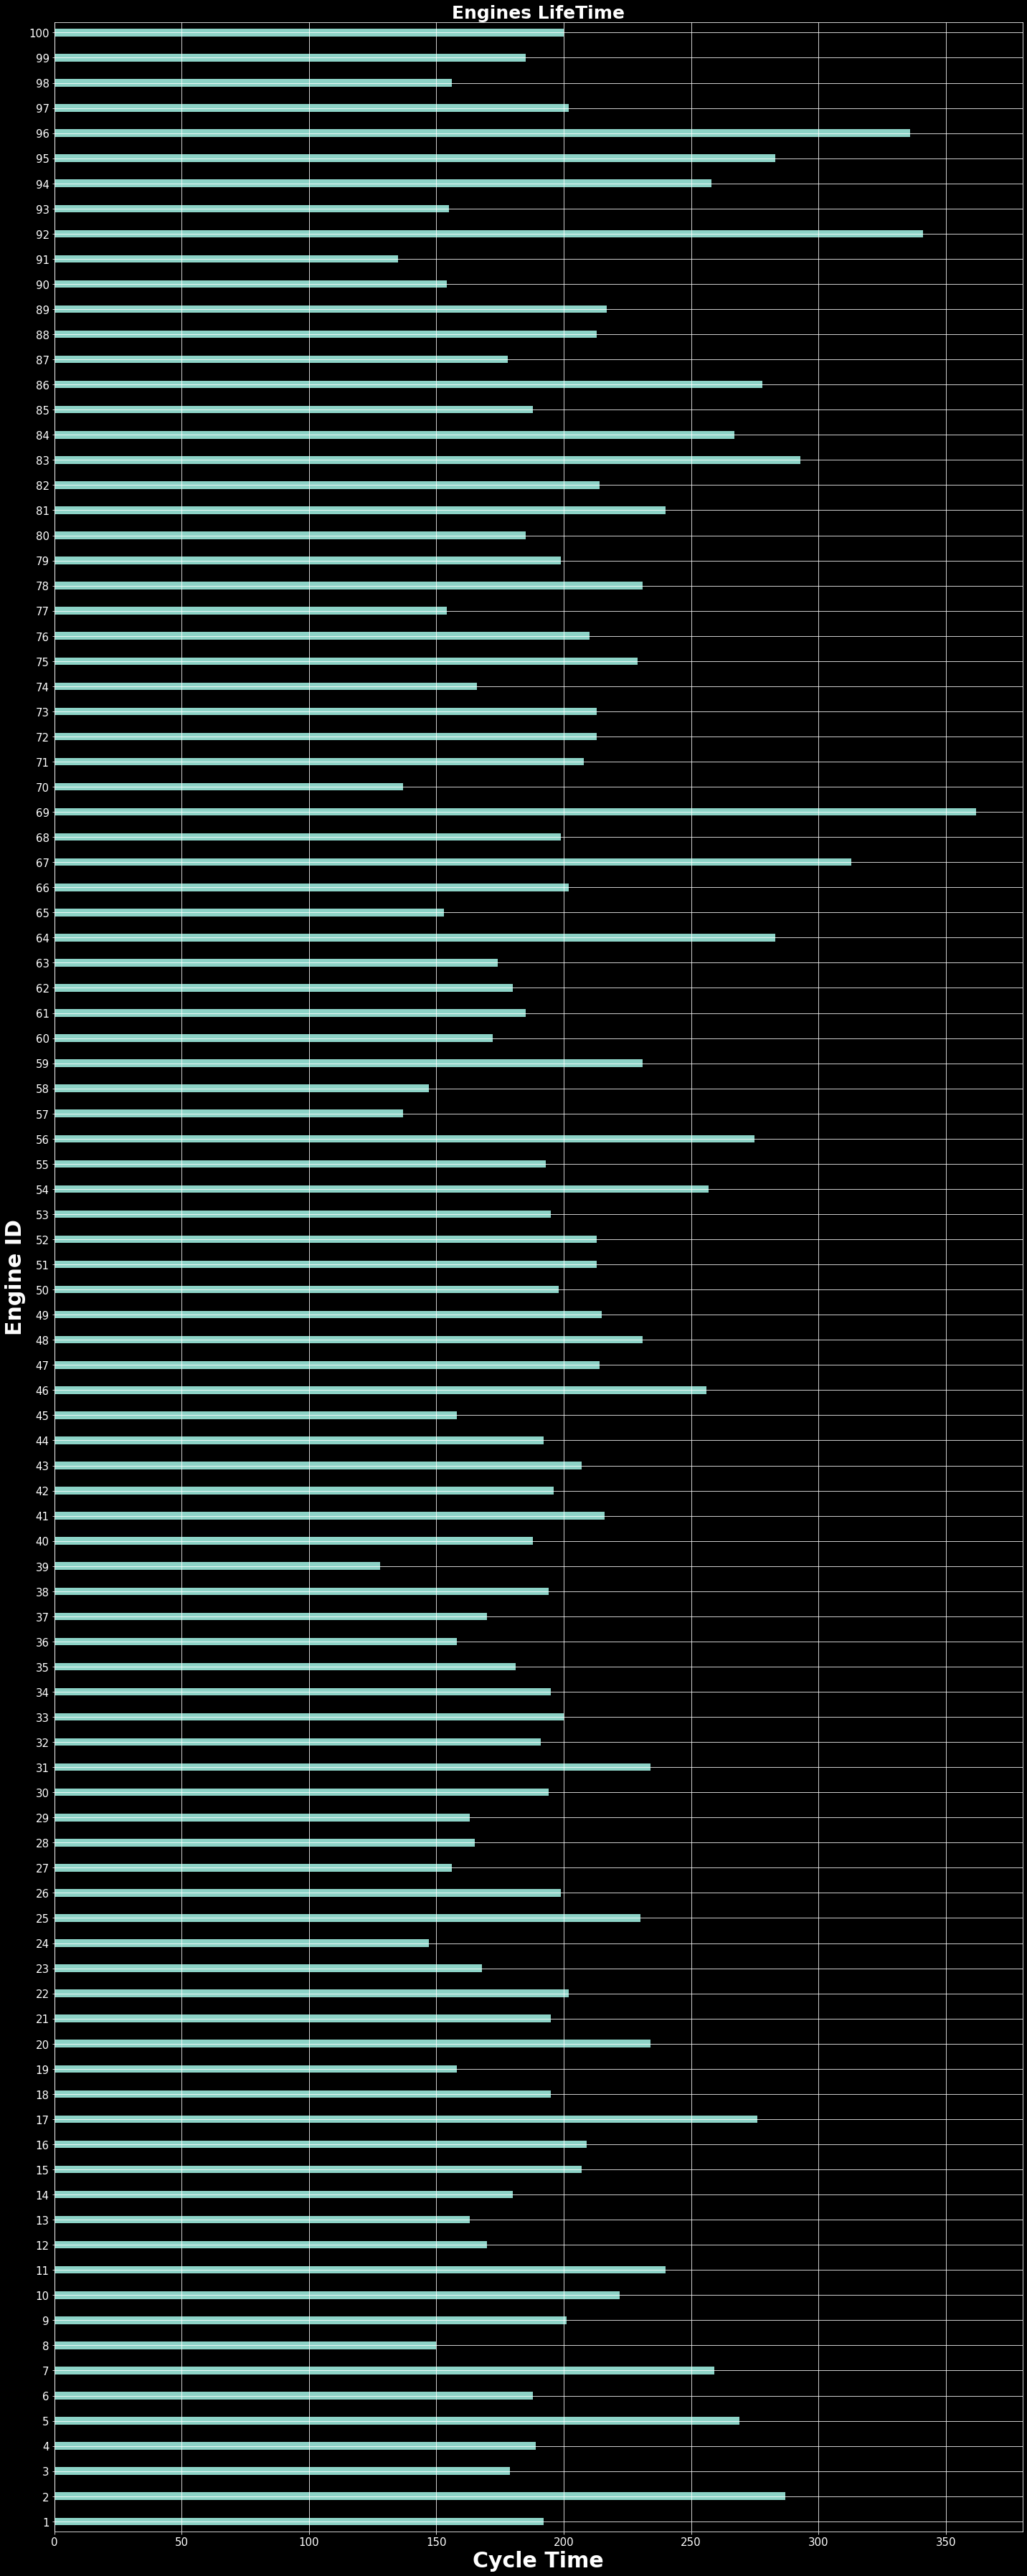

In [69]:
# extract and plot the max.'cycle' value of each unique 'engine_id'
plt.style.use('dark_background')
plt.figure(figsize=(20,50))
ax=train.groupby('engine_id')['cycle'].max().plot(kind='barh',width=0.3, stacked=True,align='center',rot=0)
plt.title('Engines LifeTime',fontweight='bold',size=25)
plt.xlabel('Cycle Time',fontweight='bold',size=30)
plt.xticks(size=15)
plt.ylabel('Engine ID',fontweight='bold',size=30)
plt.yticks(size=15)
plt.grid(True)
plt.tight_layout()
plt.show()

use remaining useful life 'rul' values of each 'engine_id' for test data

In [70]:
test_results.columns=["rul","null"]
test_results.head()

,rul,null
0,112,NaN
1,98,NaN
2,69,NaN
3,82,NaN
4,91,NaN


assign 'engine_id' to these 'rul' values

In [71]:
test_results.columns=["rul","null"]
test_results.drop(["null"],axis=1,inplace=True)
test_results['engine_id']=test_results.index+1
test_results.head()

,rul,engine_id
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5


extract max. no. of cycles run by the test engines

In [72]:
rul = pd.DataFrame(test.groupby('engine_id')['cycle'].max()).reset_index()
rul.columns = ['engine_id', 'current_cycle']
rul.head()

,engine_id,current_cycle
0,1,31
1,2,49
2,3,126
3,4,106
4,5,98


determine the total cycle at which an engine will fail using 'cycles run so far and remaining useful cycle

In [73]:
test_results['max_cycle']=test_results['rul']+rul['current_cycle']
test_results.head()

,rul,engine_id,max_cycle
0,112,1,143
1,98,2,147
2,69,3,195
3,82,4,188
4,91,5,189


drop the unwanted column

In [74]:
test_results.drop(["rul"],axis=1,inplace=True)

merge the column into test data drame

In [75]:
test=test.merge(test_results,on=['engine_id'],how='left')

add a new column to test dataframe as 'remaining_cycle'

In [77]:
test["remaining_cycle"]=test["max_cycle"]-test["cycle"]
test.head()

,engine_id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23,max_cycle,remaining_cycle
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN,143,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN,143,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN,143,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN,143,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN,143,138


In [78]:
test.isnull().sum()

engine_id              0
cycle                  0
op1                    0
op2                    0
op3                    0
sensor1                0
sensor2                0
sensor3                0
sensor4                0
sensor5                0
sensor6                0
sensor7                0
sensor8                0
sensor9                0
sensor10               0
sensor11               0
sensor12               0
sensor13               0
sensor14               0
sensor15               0
sensor16               0
sensor17               0
sensor18               0
sensor19               0
sensor20               0
sensor21               0
sensor22           13096
sensor23           13096
max_cycle              0
remaining_cycle        0
dtype: int64

drop the last two column containing all null values from train and test dataframes

In [79]:
df_train=train.drop(["sensor22","sensor23"],axis=1)
df_test=test.drop(["sensor22","sensor23"],axis=1)

drop the 'max_cycle' column as it is not required

In [81]:
df_test.drop(["max_cycle"],axis=1,inplace=True)
df_test.columns

Index(['engine_id', 'cycle', 'op1', 'op2', 'op3', 'sensor1', 'sensor2',
       'sensor3', 'sensor4', 'sensor5', 'sensor6', 'sensor7', 'sensor8',
       'sensor9', 'sensor10', 'sensor11', 'sensor12', 'sensor13', 'sensor14',
       'sensor15', 'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20',
       'sensor21', 'remaining_cycle'],
      dtype='object')

add a new column to train dataframe as 'remaining_cycle'

In [83]:
df_train['remaining_cycle'] = df_train.groupby(['engine_id'])['cycle'].transform(max)-df_train['cycle']
df_train.head()

,engine_id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,remaining_cycle
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


Let's create a new column 'label' that is assigned to each 'cycle' of each 'engine_id'

label = 1 --> if 30 or lower cycles are remaining for engine failure

label = 0 --> if more than 30 cycles are remaining for engine failure


In [88]:
cycle=30
df_train['label'] = df_train['remaining_cycle'].apply(lambda x: 1 if x <= cycle else 0)
df_test['label'] = df_test['remaining_cycle'].apply(lambda x: 1 if x <= cycle else 0)

In [87]:
op_set=["op"+str(i) for i in range(1,4)]
sensor=["sensor"+str(i) for i in range(1,22)]

In [86]:
test['engine_id'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100], dtype=int64)

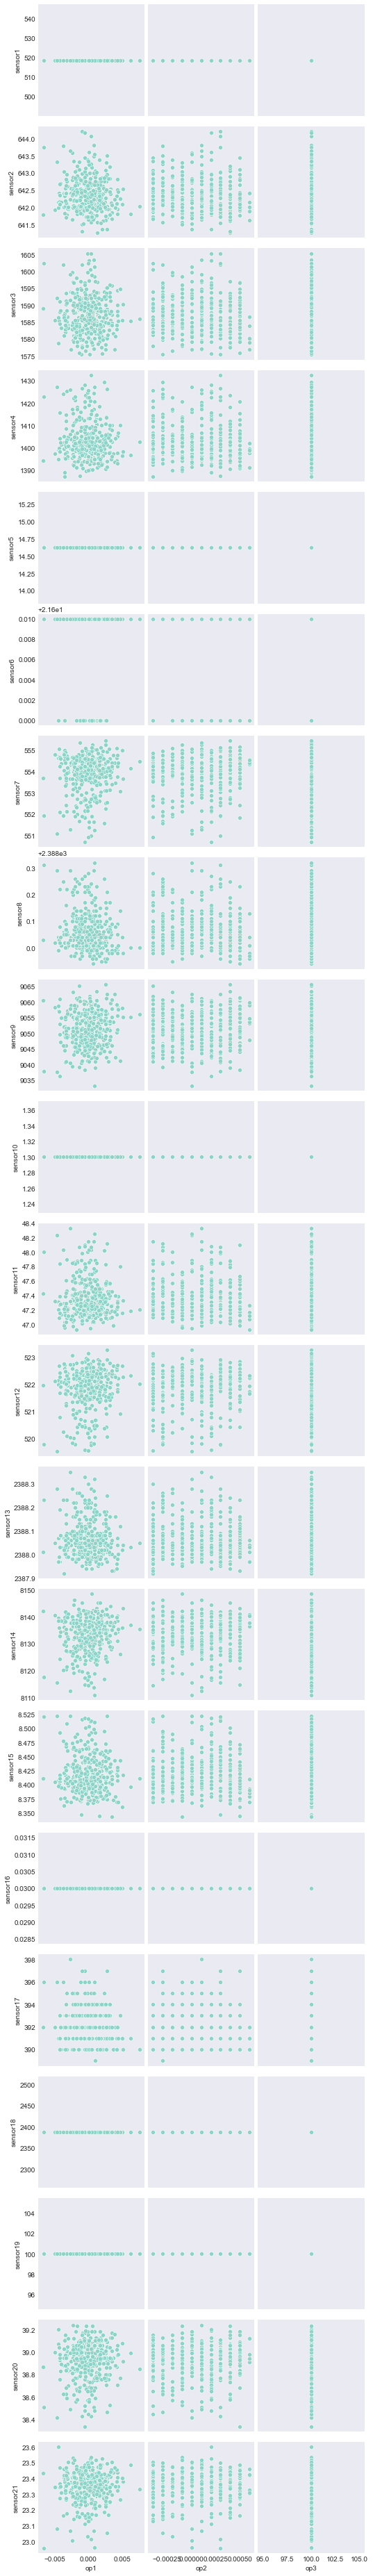

In [94]:
plt.style.use('seaborn-dark')
ax=sb.pairplot(train.query("cycle"),x_vars=op_set,y_vars=sensor)

From the above pair plot it is observed that 'op3' values doesn't change with 'engine_id' and 'cycle'.
Also, values of some sensors doesn't change with 'engine_id' and 'cycle'. 

We need to remove these unwanted columns from the dataframe 

In [93]:
df_test.drop(["engine_id","cycle","op3","sensor1","sensor5","sensor6","sensor10","sensor16","sensor18","sensor19"],axis=1,inplace=True)
df_test.head()

,op1,op2,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,remaining_cycle,label
0,0.0023,0.0003,643.02,1585.29,1398.21,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735,142,0
1,-0.0027,-0.0003,641.71,1588.45,1395.42,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916,141,0
2,0.0003,0.0001,642.46,1586.94,1401.34,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166,140,0
3,0.0042,0.0000,642.44,1584.12,1406.42,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737,139,0
4,0.0014,0.0000,642.51,1587.19,1401.92,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130,138,0


##### Prepare dataset for training and testing

In [95]:
X=df_train.drop(["engine_id","cycle","op3","sensor1","sensor5","sensor6","sensor10","sensor16","sensor18","sensor19","remaining_cycle","label"],axis=1)
Y=df_train.label
print('x shape : ',X.shape)
print('y shape : ',Y.shape)

x shape :  (20631, 16)
y shape :  (20631,)


In [97]:
X_train, X_test, Y_train, Y_test=train_test_split(X, Y, test_size=0.2, random_state=3)
print('X_train shape : ',X_train.shape)
print('X_test shape : ',X_test.shape)
print('y_train shape : ',Y_train.shape)
print('Y_test shape : ',Y_test.shape)

X_train shape :  (16504, 16)
X_test shape :  (4127, 16)
y_train shape :  (16504,)
y_test shape :  (4127,)


#### Classification using LightGBM classifier

In [98]:
# Initialize a LightGBM classifier with specific hyperparameters and train the model
lgb_clss = lgb.LGBMClassifier(learning_rate=0.01,n_estimators=5000,num_leaves=100,objective='binary', metric='auc',random_state=50,n_jobs=-1)
lgb_clss.fit(X_train, Y_train)

[LightGBM] [Info] Number of positive: 2486, number of negative: 14018
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2821
[LightGBM] [Info] Number of data points in the train set: 16504, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.150630 -> initscore=-1.729667
[LightGBM] [Info] Start training from score -1.729667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

LGBMClassifier(learning_rate=0.01, metric='auc', n_estimators=5000, n_jobs=-1,
               num_leaves=100, objective='binary', random_state=50)

Calculate scores for test data

In [101]:
lgb_clss.score(X_test, Y_test)
pred_y = lgb_clss.predict(X_test)
print('Acc Score: ',accuracy_score(Y_test, pred_y))
print('Roc Auc Score: ',roc_auc_score(Y_test, pred_y))
print('Precision Score: ',precision_score(Y_test, pred_y))
print('Recall Score: ',recall_score(Y_test, pred_y))
print('f1 score: ',f1_score(Y_test, pred_y, average='binary'))

Acc Score:  0.9590501574993943
Roc Auc Score:  0.9060580941333771
Precision Score:  0.8869565217391304
Recall Score:  0.8306188925081434
f1 score:  0.8578637510513035


In [107]:
df_test_pred = lgb_clss.predict(df_test.drop(['remaining_cycle','label'],axis=1))
print("Test Accuracy Score: ", accuracy_score(df_test.iloc[:,-1],df_test_pred))

Test Accuracy Score:  0.9860262675626146


Plot the 16 most important features using their feature score from the LightGBM classifier using a bar chart

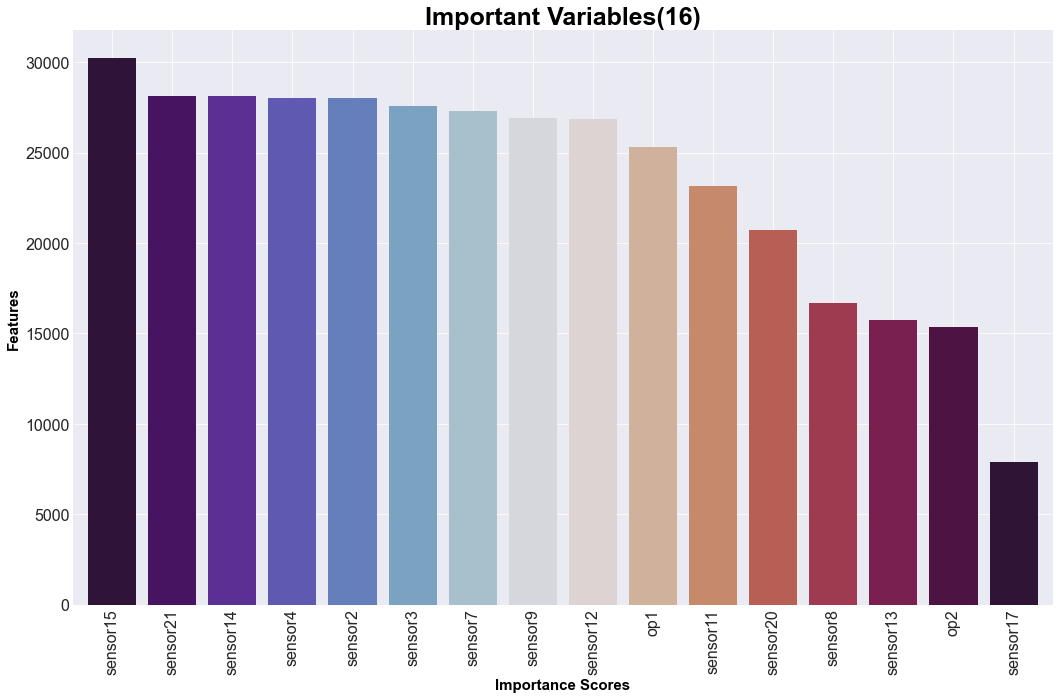

In [102]:
# Convert X_train to DataFrame with proper column names
columns_X_train=X.columns.tolist()
X_train=pd.DataFrame(X_train)
X_train.set_axis(columns_X_train, axis=1, inplace=True)
# Get feature importances from the trained LightGBM model
feat_importances = pd.Series(lgb_clss.feature_importances_, index=X_train.columns)
# Generate colors for the bars
colors = [plt.cm.twilight_shifted(i/float(len(X.columns)-1)) for i in range(len(X.columns))]
# Plot the feature importances
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 16})
plt.title('Important Variables(16)',color='black',fontweight='bold',size=25)
feat_importances.nlargest(16).plot(kind='bar', color=colors, width=0.8, align='center')
plt.ylabel('Features',color='black',fontweight='bold',size=15)
plt.xlabel('Importance Scores',color='black',fontweight='bold',size=15)
plt.tight_layout()
plt.grid(True)
plt.show()

#### Classification using XGBoost classifier

Set up a Randomized Search Cross-Validation (RandomizedSearchCV) for tuning hyperparameters of an XGBoost classifier.
This process helps automate the hyperparameter tuning process using randomized search over specified parameter distributions, making it easier to find optimal parameters for XGBoost model.

In [105]:
# Define a Stratified K-Fold cross-validator with 5 splits. 
# This is used for cross-validation during the hyperparameter tuning process.
stf_kf=StratifiedKFold(n_splits=5)
# Initialize an XGBoost classifier with 725 estimators (trees) and uses all available cores 
xgb_classifier=xgb.XGBClassifier(n_estimators=725,n_jobs=-1)
# Define a dictionary params containing ranges for various XGBoost hyperparameters that will be tuned during Randomized Search CV.
params={
         'learning_rate': np.arange(0.01, 0.11, 0.025),
         'max_depth': np.arange(1, 10, 1),
         'min_child_weight': np.arange(1, 10, 1), 
         'subsample': np.arange( 0.7, 1, 0.05), 
         'gamma': np.arange(0.5, 1, 0.1), 
         'colsample_bytree': np.arange( 0.1, 1, 0.05), 
         'scale_pos_weight': np.arange( 20, 200, 10)}

# Initialize the RandomizedSearchCV with XGBoost classifier 
rs_cv_classifier=RandomizedSearchCV(xgb_classifier,param_distributions=params,cv=stf_kf,n_jobs=-1)
# train the model
rs_cv_classifier.fit(X_train,Y_train)
# make prediction for test data
y_pred=rs_cv_classifier.predict(X_test)
print("Best Parameter: \n",rs_cv_classifier.best_params_)
print("XGBClassifier Acc Score: ",accuracy_score(y_pred,Y_test))

Best Parameter: 
 {'subsample': 0.9000000000000001, 'scale_pos_weight': 70, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.060000000000000005, 'gamma': 0.7999999999999999, 'colsample_bytree': 0.3500000000000001}
XGBClassifier Acc Score:  0.9549309425732978


Calculate accuracy for test data

In [108]:
df_test_pred = rs_cv_classifier.predict(df_test.drop(['remaining_cycle','label'],axis=1))
print("Test Accuracy Score: ", accuracy_score(df_test.iloc[:,-1],df_test_pred))

Test Accuracy Score:  0.9824373854612095


<AxesSubplot:>

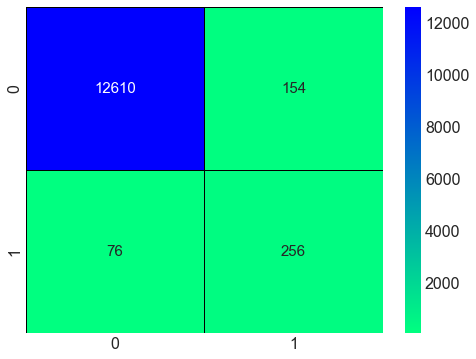

In [117]:
cm=confusion_matrix(df_test.iloc[:,-1], df_test_pred, labels=None, sample_weight=None)
plt.figure(figsize=(8,6))
sb.heatmap(cm,annot=True,annot_kws={"size": 15},linewidths=0.5,linecolor="black",cmap="winter_r",fmt="d")